# Computer Vision Lecture - Exercise 1 - Image Formation

In this exercise, you will gain hands-on experience regarding the image formation process and geometric transformations. More specifically, we will develop our own simple renderer and play around with focal lengths, BRDF-based shading, rotations, translations, and much more! In the second part of the notebook, we will have a look at homographies and how they can be used to stitch together images to form panoramas.

This notebook guides you through the relevant steps. When you see helper functions, you don't need to do anything - they are already implemented. The functions you need to implement are indicated as Exercise Function. Sometimes, you can find Hints - these are written upside-down so you can first try to find the solution without reading them.

Good luck and lot's of fun!

## Preliminaries

Let's first import relevant libaries and define hyperparameters. For the latter, we set the image height H and width W to 128 pixels.

In [38]:
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from IPython.display import HTML
from matplotlib import animation
from matplotlib.patches import Polygon
import cv2

# Let's first define hyperparameters. In our case, we set the image height H and width H to 128 pixels
H, W = 128, 128

In order to display the animation in HTML format (e.g., using anim.to_html5_video()), which is required to visualize the **Dolly Zoom effect**, you need to have FFmpeg installed on your system. FFmpeg is used by matplotlib to encode the animation into a video format.

You can install it via the following commands:

**For Ubuntu/Linux:**
```bash
sudo apt update
sudo apt install ffmpeg
```

**For macOS (with Homebrew):**
```bash
brew install ffmpeg
```

**For Windows (via Chocolatey):**
```bash
choco install ffmpeg
```

Alternatively, you can download FFmpeg manually from the official website: 
https://ffmpeg.org/download.html. After installation, make sure ffmpeg is accessible from your terminal (i.e., in your system PATH). You can verify this by running `bash ffmpeg -version`. 
If you are using Google Colab, FFmpeg is usually pre-installed and no action is needed.

We need an object in our scene in order to render more than an empty image! For this, we define a helper function which returns the faces (and optionally the face normals) of a cube.

我们需要一个对象在我们的场景中，以渲染更多的空图像！为此，我们定义了一个辅助函数，它返回立方体的面（以及可选的面法线）。

In [ ]:
###########################
##### Helper Function #####
###########################


def get_cube(center=(0, 0, 2), rotation_angles=[0., 0., 0.], with_normals=False, scale=1.):
    ''' Returns an array containing the faces of a cube.

    Args:
    center (tuple): center of the cube
    rotation_angles (tuple): Euler angles describing the rotation of the cube
    with_normals (bool): whether to return the normal vectors of the faces
    scale (float): scale of cube

    '''
    # A cube consists of 6 faces and 8 corners:
    #   +----+
    #  /    /|
    # +----+ |
    # |    | +
    # |    |/
    # +----+
    # Let's first consider the unit cube. The corners are:
    corners = np.array([(0, 0, 0), (0, 0, 1), (0, 1, 0),
                       (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)])
    # Let's now center the cube at (0, 0, 0)
    corners = corners - np.array([0.5, 0.5, 0.5],
                                 dtype=np.float32).reshape(1, 3)
    # Let's scale the cube
    corners = corners * scale
    # And we rotate the cube wrt. the input rotation angles
    rot_mat = R.from_euler('xyz', rotation_angles, degrees=True).as_matrix()
    corners = np.matmul(corners, rot_mat.T)
    # Finally, we shift the cube according to the input center tuple
    corners = corners + np.array(center, dtype=np.float32).reshape(1, 3)

    # The 6 faces of the cube are then given as:
    faces = np.array([
        # all faces containing (0, 0, 0)
        [corners[0], corners[1], corners[3], corners[2]],
        [corners[0], corners[1], corners[5], corners[4]],
        [corners[0], corners[2], corners[6], corners[4]],
        # all faces containing (1, 1, 1)
        [corners[-1], corners[-2], corners[-4], corners[-3]],
        [corners[-1], corners[-2], corners[-6], corners[-5]],
        [corners[-1], corners[-3], corners[-7], corners[-5]],
    ])

    if with_normals:
        normals = np.array(
            [(-1, 0, 0), (0, -1, 0), (0, 0, -1), (1, 0, 0), (0, 1, 0), (0, 0, 1)])
        normals = np.matmul(normals, rot_mat.T)
        return faces, normals
    else:
        return faces

## 2.1 Perspective Projection

In the first part of the exercise, we will use the pinhole camera model which performs a perspective projection. After developing the projection and shading functions, we will play around with geometric transformations and analyze the effect of the focal lengths!

2.1 透视投影
在练习的第一部分，我们将使用针孔相机模型进行透视投影。
在开发投影和着色函数后，我们将尝试几何变换，并分析焦距的影响！

### a)
We arrive at our first exercise function. Your task is complete the function get_camera_intrinsics which returns a 3x3 camera matrix for provided focal lengths fx, fy and the principal point (cx, cy).

我们得到了第一个运动函数。你的任务是完成函数get_camera_intrinsics，它返回一个3x3相机矩阵提供焦距fx， fy和主点（cx, cy）。

In [3]:
###########################
#### Exercise Function ####
###########################
def get_camera_intrinsics(fx=70, fy=70, cx=W/2., cy=H/2.):
    ''' Returns the camera intrinsics matrix.

    Hint: The array should be of size 3x3 and of dtype float32 (see the assertion below)

    Args:
    fx (float): focal length in x-direction f_x
    fy (float): focal length in y-direction f_y
    cx (float): x component of the principal point
    cy (float): y compontent of th principal point
    '''

    # Insert your code here
    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0, 0, 1]], dtype=np.float32)
    # End of your code
    assert (K.shape == (3, 3) and K.dtype == np.float32)
    return K

### b)

We now develop the function `get_perspective_projection`. It takes in a 3D point in camera space `x_c` and the camera matrix `K` and it returns the point in screen space (i.e. the pixel coordinates) `x_s`. Note that we return a 2D vector for `x_s` as we drop the final value (which is always 1).

现在我们开发函数“get_perspective_projection”。它在相机空间“x_c”和相机矩阵“K”中获取一个3D点，并返回屏幕空间中的点（即像素坐标）。“间”。请注意，当我们删除最终值（总是1）时，我们为‘ x_s ’返回一个2D向量。

In [4]:
def get_perspective_projection(x_c, K):
    ''' Projects the 3D point x_c to screen space and returns the 2D pixel coordinates.

    Args:
        x_c (array): 3D point in camera space
        K (array): camera intrinsics matrix (3x3)
    '''
    assert (x_c.shape == (3,) and K.shape == (3, 3))  # 断言，如果不成立就会报错

    # Insert your code here
    K_new = np.hstack((K, np.zeros((3, 1), dtype=K.dtype)))  # 将K扩展为4x3矩阵
    x_c_h = np.append(x_c, 1)  # 将x_c转换为齐次坐标
    x_s_h = np.matmul(K_new, x_c_h)  # 进行矩阵乘法。4x3矩阵乘以4x1向量，得到3x1向量
    x_s = x_s_h[:2] / x_s_h[2]  # 将结果转换为非齐次坐标。[:2]表示取前两个元素，/ x_s_h[2]表示除以第三个元素
    # End of your code
    assert (x_s.shape == (2,))  # 断言，确保输出是一个2D向量
    return x_s

Here, we provide a helper function to project the entire cube using the camera matrix K.

在这里，我们提供了一个辅助函数来使用相机矩阵K投影整个立方体。

In [5]:
###########################
##### Helper Function #####
# 这个函数的作用是将三维立方体的所有顶点通过相机内参矩阵 K 投影到二维像素平面上，得到每个面的二维坐标。
def project_cube(cube, K):
    ''' Projects the cube.

    Args:
        cube (array): cube
        K (array): camera intrinsics matrix
    '''
    s = cube.shape  # 保存原始 cube 的形状，方便后续恢复。
    assert (s[-1] == 3)  # 确保最后一个维度是3，表示每个点的三维坐标。
    cube = cube.reshape(-1, 3)  # -1 表示自动计算该维度的大小，3 表示每个点有3个坐标（x, y, z）。
    # 展开立方体的所有顶点，使其成为一个二维数组，每行表示一个三维点。
    # 这样做是为了方便对每个点进行投影操作。
    # 使用列表推导式和 np.stack 将每个三维点投影到二维平面上。
    # 对 cube 中的每个三维点 p，使用 get_perspective_projection 函数进行投影，得到二维像素坐标。
    projected_cube = np.stack([get_perspective_projection(p, K) for p in cube])
    projected_cube = projected_cube.reshape(*s[:-1], 2)
    # 将投影后的二维点重新塑形为与原始 cube 相同的结构，但最后一个维度变为2，表示每个点的二维坐标。
    # 返回投影后的立方体二维坐标。
    return projected_cube

To see if our developed functions make sense, let's have a look at a projection! But first, we need to write a function which plots the projected cube - this is provided here.


##### 作用
这个函数用于**可视化投影后的立方体**，即把三维立方体经过投影变换后得到的二维顶点坐标，绘制在 matplotlib 的画布上。

##### 参数说明
- `projected_cube`：形状为 (6, 4, 2) 的 numpy 数组，表示立方体的 6 个面，每个面有 4 个顶点，每个顶点是二维坐标（像素位置）。
- `figsize`：画布大小。
- `figtitle`：图像标题。
- `colors`：每个面的颜色列表，默认全部是 'C0'（蓝色）。
- `face_mask`：每个面的可见性掩码，True 表示绘制该面，False 表示不绘制。

##### 实现原理
1. **断言输入形状**：确保输入的 `projected_cube` 是 6 个面，每面 4 个顶点，每个顶点 2 维。
2. **创建画布**：用 `plt.subplots` 创建画布和坐标轴。
3. **设置标题**：如果有标题则设置。
4. **颜色和掩码处理**：如果没有指定颜色或掩码，则全部用默认值。
5. **设置坐标轴范围和标签**：x 轴宽度范围 [0, W]，y 轴高度范围 [0, H]。
6. **绘制每个面**：遍历每个面、颜色和掩码，如果该面可见（mask 为 True），则用 `Polygon` 绘制多边形。
7. **显示图像**：调用 `plt.show()` 展示结果。

##### 总结
这个函数就是把已经投影到二维平面的立方体各个面，按照指定颜色和可见性，画出来，方便你直观观察投影效果和立方体的空间关系。

In [6]:
###########################
##### Helper Function #####
###########################
def plot_projected_cube(projected_cube, figsize=(5, 5), figtitle=None, colors=None, face_mask=None):
    ''' Plots the projected cube.
    Args:
    projected_cube (array): projected cube (size 6x4x2)
    figsize (tuple): size of the figure
    colors (list): list of colors for polygons. If None, 'blue' is used for all faces
    face_mask (array): mask for individual faces of the cube. If None, all faces are drawn.
    '''
    assert (projected_cube.shape == (6, 4, 2))  # 断言，确保输入的 projected_cube 形状正确。
    # 创建一个新的图形和坐标轴对象，设置图形大小为 figsize。
    # 如果提供了 figtitle，则设置图形的标题。
    # 如果 colors 参数为 None，则为每个面分配默认颜色 'C0'（蓝色）。
    # 如果 face_mask 参数为 None，则创建一个全为 True 的掩码，表示绘制所有面。
    fig, ax = plt.subplots(figsize=figsize)
    if figtitle is not None:
        fig.suptitle(figtitle)
    if colors is None:
        colors = ['C0' for i in range(len(projected_cube))]
    if face_mask is None:
        face_mask = [True for i in range(len(projected_cube))]
    # 设置坐标轴的 x 和 y 轴范围，以及标签。
    ax.set_xlim(0, W), ax.set_ylim(0, H)
    ax.set_xlabel('Width'), ax.set_ylabel("Height")
    # 遍历每个立方体面、对应的颜色和掩码。 zip 函数将三个可迭代对象打包在一起，方便同时遍历。
    # 如果掩码为 True，则使用 Polygon 类创建一个多边形对象，
    for (cube_face, c, mask) in zip(projected_cube, colors, face_mask):
        if mask:
            ax.add_patch(Polygon(cube_face, color=c))

    # Polygon 类用于创建一个多边形对象，传入的参数包括多边形的顶点坐标和颜色。
    # add_patch 方法将多边形添加到坐标轴中进行绘制。
    # 可以忽略遮挡关系，直接绘制所有面。
    plt.show()

Let's have a look at our first rendering of a cube! We get our camera matrix `K` and the cube `cube`, then we project it using the `project_cube` function, and finally we can visualize the projection using the `plot_projected_cube function`.

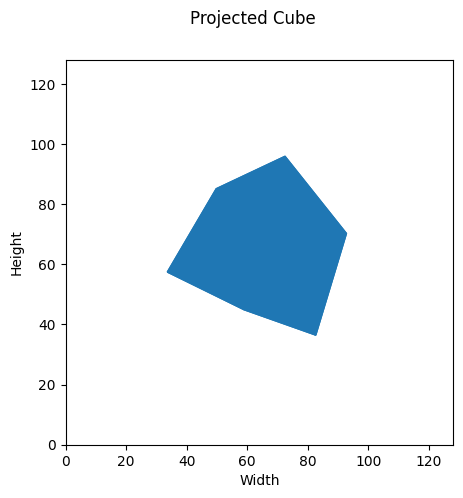

In [7]:
K = get_camera_intrinsics()
cube = get_cube(rotation_angles=[30, 50, 0])
projected_cube = project_cube(cube, K)
plot_projected_cube(projected_cube, figtitle='Projected Cube')

Doesn't look too bad! However, all faces have the same color, so we cannot really see which face of the cube is in front. For this, let's develop a simple shading function next!

### c)

We now develop the function `get_face_color`. For the input `normal` of a cube face and the `point_light direction` vector for a point light source, we calculate the color intensity using the rendering equation. We then stack the color intensity three times to obtain a RGB color value (scaled between 0.1 and 0.9 to avoid pure white/black). For calculating the light intensity, have a closer look at the rendering equation discussed in the lecture. You can assume that the surface does not emit light and that the BRDF term is always 1. The incoming light is exactly 1 for the direction of the point light source.

### c) 
 
现在我们开发函数‘ get_face_color ’。对于立方体面的“法线”输入和点光源的“point_light direction”向量，我们使用渲染方程计算颜色强度。然后我们将颜色强度叠加三次以获得RGB颜色值（在0.1和0.9之间缩放以避免纯白色/黑色）。为了计算光强度，请仔细查看讲座中讨论的渲染方程。你可以假设表面不发光并且BRDF项总是1。入射光正好是点光源方向的1。

##### Render equation:
$L_{out}(x, w_o) = L_{emit}(x, w_o) + \int_{\Omega_x} L_{in}(x, w_i) BRDF(x, w_i, w_o) cos(\theta_i) dw_i$

In [8]:
###########################
#### Exercise Function ####
###########################
def get_face_color(normal, point_light_direction=(0, 0, 1)):
    ''' Returns the face color for input normal.

    Args:
        normal (array): 3D normal vector
        point_light_direction (tuple): 3D point light direction vector
    '''
    # assumption: L_{emit} = 0, BRDF() = 1 理想漫反射
    assert (normal.shape == (3,))  # 断言，确保输入的 normal 是一个三维向量
    point_light_direction = np.array(point_light_direction, dtype=np.float32)

    # Insert your code here
    normal = normal / np.linalg.norm(normal)
    point_light_direction = point_light_direction / \
        np.linalg.norm(point_light_direction)
    light_intensity = - np.dot(normal.T, point_light_direction)

    color_intensity = 0.1 + (light_intensity * 0.5 + 0.5) * 0.8
    color = np.stack([color_intensity for i in range(3)])
    return color

We provide a helper function which returns the face colors for multiple normals by looping over them and returning stacking the output of the `get_face_color` function.

In [9]:
###########################
##### Helper Function #####
###########################
def get_face_colors(normals, light_direction=(0, 0, 1)):
    ''' Returns the face colors for given normals and viewing direction.

    Args:
    normals (array): face normals (last dimension is 3)
    light_direction (tuple): light direction vector
    '''
    colors = np.stack([get_face_color(normal, light_direction)
                      for normal in normals])
    return colors

When using different colors for the cube faces, we now also need to reason about which face is visible in the image. This function is provided in the following. We use a very simple heuristic here based on the face normals and the viewing direction which works for our examples.

In [10]:
###########################
##### Helper Function #####
###########################
def get_face_mask(cube, normals, camera_location=(0, 0, 0)):
    ''' Returns a mask for each face of the cube whether it is visible when projected.

    Args:
    cube (array): cube faces
    normals (array): face normals (last dimension is 3)
    camera_location (tuple): viewing camera location vector
    '''
    assert (cube.shape == (6, 4, 3)
            and normals.shape[-1] == 3)  # 断言，确保输入的 cube 和 normals 形状正确
    # 将 camera_location 转换为 numpy 数组，并调整形状为 (1, 3)，方便后续计算。
    # 计算每个面的中心点 face_center，这是通过对每个面的四个顶点取平均值实现的。
    # 计算从相机位置到每个面中心的视线方向 viewing_direction。
    # 计算法线向量与视线方向的点积 dot_product。
    # 如果点积大于0，说明该面朝向相机，是可见的；否则，该面背向相机，是不可见的。
    # 返回一个布尔数组 mask，表示每个面是否可见。
    camera_location = np.array(camera_location).reshape(1, 3)

    face_center = np.mean(cube, axis=1)
    viewing_direction = camera_location - face_center
    dot_product = np.sum(normals * viewing_direction, axis=-1)
    mask = dot_product > 0.0
    return mask

Great, let's have a look at our projected cube with shading!

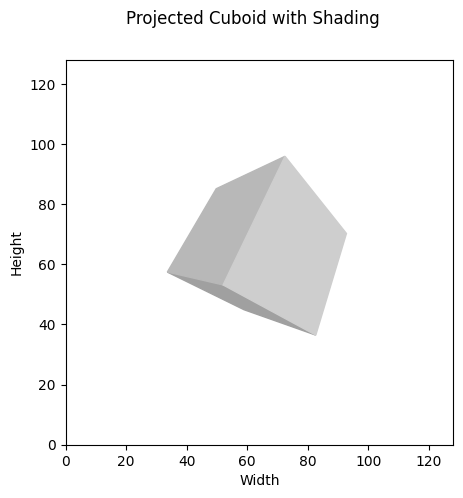

In [11]:
cube, normals = get_cube(rotation_angles=[30, 50, 0], with_normals=True)
colors = get_face_colors(normals)  # 计算每个面的颜色
mask = get_face_mask(cube, normals)  # 计算每个面的可见性
# 重新投影立方体并绘制带有阴影的投影立方体
# projected_cube的作用是将三维立方体的顶点通过相机内参矩阵 K 投影到二维像素平面上，得到每个面的二维坐标。
projected_cube = project_cube(cube, get_camera_intrinsics())
plot_projected_cube(
    projected_cube, figtitle="Projected Cuboid with Shading", colors=colors, face_mask=mask)

Looks much better, right? We can see that **shading is a strong cue for reasoning about 3D geometry**. In the following, we will create animations where we rotate the cube or change the focal lengths.

The next function `get_animation` returns a matplotlib animation for given lists of camera matrices and cubes.

In [12]:
###########################
##### Helper Function #####
###########################
def get_animation(K_list, cube_list, figsize=(5, 5), title=None):
    ''' Create a matplotlib animation for the list of camera matrices and cubes with face normals.

    Args:
    K_list (list): list of camera matrices
    cube_list (list): list of cubes
    figsize (tuple): matplotlib figsize
    title (str): if not None, the title of the figure
    '''
    assert (len(K_list) == len(cube_list))

    # split cube_list into cubes and normals
    cubes = [i[0] for i in cube_list]
    normals = [i[1] for i in cube_list]

    # get face colors and masks
    colors = [get_face_colors(normals_i) for normals_i in normals]
    masks = [get_face_mask(cube_i, normals_i)
             for (cube_i, normals_i) in zip(cubes, normals)]

    # get projected cubes
    projected_cubes = [project_cube(cube, Ki)
                       for (cube, Ki) in zip(cubes, K_list)]

    # initialize plot
    uv = projected_cubes[0]
    patches = [Polygon(uv_i, closed=True, color='white') for uv_i in uv]

    # Define animation function
    def animate(n):
        ''' Animation function for matplotlib visualizations.
        '''
        uv = projected_cubes[n]
        color = colors[n]
        mask = masks[n]
        for patch, uv_i, color_i, mask_i in zip(patches, uv, color, mask):
            if mask_i:
                patch.set_xy(uv_i)
                patch.set_color(color_i)
            else:
                uv_i[:] = -80
                patch.set_color(color_i)
                patch.set_xy(uv_i)
        return patches

    fig, ax = plt.subplots(figsize=figsize)
    if title is not None:
        fig.suptitle(title)
    plt.close()
    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    for patch in patches:
        ax.add_patch(patch)
    anim = animation.FuncAnimation(
        fig, animate, frames=len(K_list), interval=100, blit=True)
    return anim

With this helper function, we can now create cool animations! Let's start off with creating a list of camera matrices and a list of cubes with normals where we rotate the cube along the y-axis.

In [13]:
K_list = [get_camera_intrinsics() for i in range(30)]
cube_list = [get_cube(rotation_angles=[0, angle, 0], with_normals=True)
             for angle in np.linspace(0, 360, 30)]
anim = get_animation(K_list, cube_list, title="Rotation of Cube")
HTML(anim.to_html5_video())

Next, we can analyze the effect of changing the focal lenghs. Let's start with the focal length in x-direction.

In [14]:
K_list = [get_camera_intrinsics(fx=f) for f in np.linspace(10, 150, 30)]
cube_list = [get_cube(rotation_angles=[30, 50, 0], with_normals=True)
             for i in range(30)]
anim = get_animation(
    K_list, cube_list, title="Change of focal length along the x-axis.")
HTML(anim.to_html5_video())

### d) + e)

Create a visualization where you change both focal lengths similarly to the previous example. Further, create a visualization where you translate the cube along the y-axis between the values [-2, 2].

创建一个可视化，其中您可以像前面的示例一样更改两个焦距。此外，创建一个可视化，在该可视化中，您可以在值[- 2,2]之间沿y轴平移立方体。

*Hint 1*: ˙uoᴉʇɔunɟ ǝqnɔ‾ʇǝƃ ǝɥʇ ɟo ʇuǝɯnƃɹɐ ɹǝʇuǝɔ ǝɥʇ ǝʇɐlndᴉuɐɯ 'ǝqnɔ ǝɥʇ ƃuᴉʇɐlsuɐɹʇ ɹoℲ

In [15]:
###########################
#### Exercise Function ####
###########################
# Insert your code here

K_list = [get_camera_intrinsics(fy=f) for f in np.linspace(10, 150, 30)]
cube_list = [get_cube(rotation_angles=[30, 50, 0], with_normals=True)
             for i in range(30)]
anim = get_animation(
    K_list, cube_list, title="Change of focal length along the y-axis.")
HTML(anim.to_html5_video())

In [16]:
###########################
#### Exercise Function ####
###########################
# Insert your code here

K_list = [get_camera_intrinsics() for i in range(30)]
# ls1,ls2 = get_cube(rotation_angles=[30, 50, 0], with_normals=True) # 调试输出
# print(ls1.shape)
cube_list = [get_cube(center=(0, i, 2), rotation_angles=[
                      30, 50, 0], with_normals=True) for i in np.linspace(-2, 2, 30)]
anim = get_animation(
    K_list, cube_list, title="Change of place translation along the y-axis.")
HTML(anim.to_html5_video())

### f) Dolly Zoom Effect

Great! As you are now familiar with manipulating the focal lengths as well as translating the object, we can now even create the Dolly Zoom effect! 

For this, linearly change the **focal lengths from 10 to 150** (zoom-in), while also **translating the cube along the z-axis from 0.9** (close to the camera at $z = 0$) to **5** (away from the camera, dolly-out).

太棒了!由于您现在熟悉操纵焦距以及翻译对象，我们现在甚至可以创建多莉变焦效果！ 
 
为此，线性改变焦距从10到150**（放大），同时也**转换立方体沿z轴从0.9**（接近相机在$z = 0$）到**5**（远离相机，小车）。

In [17]:
###########################
#### Exercise Function ####
###########################
# 1) Simulates zooming in as the focal length increases:

# Insert your code here
K_list = [get_camera_intrinsics(fx=i, fy=i) for i in np.linspace(10, 150, 30)]

# 2) Move the cube along the z-axis:
cube_list = [get_cube(center=(0, 0, i), rotation_angles=[30, 50, 0], with_normals=True)
             for i in np.linspace(0.9, 5, 30)]

# Insert your code here
anim = get_animation(
    K_list, cube_list, title="moving cube with changing focal length")
HTML(anim.to_html5_video())

Additionally, we create two fixed background cubes at a farther distance (z=5). These help make the perspective change more noticeable during dolly zoom.

In [18]:
left_reference_cube = get_cube(center=(-2.5, 0, 5), with_normals=True)
right_reference_cube = get_cube(center=(2.5, 0, 5), with_normals=True)

The next function `get_animation_with_refs` returns a 2D animation that visualizes a moving cube and fixed background objects under varying camera intrinsics, useful for demonstrating effects like dolly zoom.

In [19]:
###########################
##### Helper Function #####
###########################
def get_animation_with_refs(K_list, main_cube_list, static_refs, figsize=(5, 5), title=None):
    ''' Create a matplotlib animation for the list of camera matrices and cubes with face normals.

    Args:
    K_list (list): list of camera matrices
    main_cube_list: List of (faces, normals) tuples for each frame's main cube
    static_refs: List of (faces, normals) tuples (added to every frame)
    figsize (tuple): matplotlib figsize
    title (str): if not None, the title of the figure
    '''
    def merge_cubes(cube_list):
        """
        Merge multiple cube representations (each of shape (6, 4, 3)) into a single cube
        by stacking them along axis 0 (i.e., treat them as separate faces).
        """
        all_faces = [cube[0]
                     for cube in cube_list]  # Each cube[0] is (6, 4, 3)
        all_normals = [cube[1] for cube in cube_list]  # Each cube[1] is (6, 3)
        # shape (6*num_cubes, 4, 3)
        merged_faces = np.concatenate(all_faces, axis=0)
        merged_normals = np.concatenate(
            all_normals, axis=0)  # shape (6*num_cubes, 3)
        return (merged_faces, merged_normals)

    cube_list = [merge_cubes([main_cube, ] + static_refs)
                 for main_cube in main_cube_list]
    assert (len(K_list) == len(cube_list))

    # split cube_list into cubes and normals
    cubes = [i[0] for i in cube_list]
    normals = [i[1] for i in cube_list]

    # get face colors and masks
    def get_face_masks(cube, normals, camera_location=(0, 0, 0)):
        # here the stacked cube shape is (6*num_cubes=18, 4, 3)
        assert (cube.shape[1:] == (4, 3) and normals.shape[-1] ==
                3), f"cube shape: {cube.shape}, normals shape: {normals.shape}"
        camera_location = np.array(camera_location).reshape(1, 3)
        face_center = np.mean(cube, axis=1)
        viewing_direction = camera_location - face_center
        dot_product = np.sum(normals * viewing_direction, axis=-1)
        mask = dot_product > 0.0
        return mask

    colors = [get_face_colors(normals_i) for normals_i in normals]
    masks = [get_face_masks(cube_i, normals_i)
             for (cube_i, normals_i) in zip(cubes, normals)]

    # get projected cubes
    projected_cubes = [project_cube(cube, Ki)
                       for (cube, Ki) in zip(cubes, K_list)]

    # initialize plot
    uv = projected_cubes[0]
    patches = [Polygon(uv_i, closed=True, color='white') for uv_i in uv]

    # Define animation function
    def animate(n):
        ''' Animation function for matplotlib visualizations.
        '''
        uv = projected_cubes[n]
        color = colors[n]
        mask = masks[n]
        for patch, uv_i, color_i, mask_i in zip(patches, uv, color, mask):
            if mask_i:
                patch.set_xy(uv_i)
                patch.set_color(color_i)
            else:
                uv_i[:] = -80
                patch.set_color(color_i)
                patch.set_xy(uv_i)
        return patches

    fig, ax = plt.subplots(figsize=figsize)
    if title is not None:
        fig.suptitle(title)
    plt.close()
    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    for patch in patches:
        ax.add_patch(patch)
    anim = animation.FuncAnimation(
        fig, animate, frames=len(K_list), interval=100, blit=True)
    return anim

Now we can finally render the dolly zoom animation with the given camera intrinsics and cube setup:

In [20]:
anim = get_animation_with_refs(
    K_list,
    main_cube_list=cube_list,
    static_refs=[left_reference_cube, right_reference_cube],
    title="Dolly Zoom Effect with Reference Cubes")
HTML(anim.to_html5_video())

Great! If you implemented it correctly, **the size of the central cube** should remains roughly constant, while **the two reference cubes** appear to move toward and grow larger, creating a strong sense of perspective change (this effect has also been used in movies, check out https://en.wikipedia.org/wiki/Dolly_zoom for more information).

## 2.2 Comparison of Perspective and Orthographic Projection

We have now seen the effect of a perspective transformation. Let's contrast this against an orthographic projection in the following!

### a)

Complete the function `get_orthographic_projection` which maps an input point in camera space `x_c` to 2D pixel coordinates `x_s`.

透视和正射影的比较 
 
现在我们已经看到了透视转换的效果。下面让我们将其与正射影进行对比！ 
 
### a) 
 
完成函数`get_orthographic_projection`，将相机空间`x_c`中的输入点映射到2D像素坐标`x_s`。

In [21]:
###########################
#### Exercise Function ####
###########################
def get_orthographic_projection(x_c):
    # 计算单个点的投影
    ''' Projects the 3D point in camera space x_c to 2D pixel coordinates using an orthographic projection.

    Args:
        x_c (array): 3D point in camera space
    '''
    assert (x_c.shape == (3,))

    # Insert your code here
    x_s = np.array([x_c[0], x_c[1]], dtype=np.float32)  # 只取x和y坐标
    assert (x_s.shape == (2,))
    return x_s

Here, we provide a helper function to project the entire cube using the `get_orthographic_projection` function.

In [22]:
def project_cube_orthographic(cube):
    # 计算整个cube的投影
    ''' Projects the cube using an orthographic projection.

    Args:
        cube (array): cube
    '''
    s = cube.shape
    assert (s[-1] == 3)
    cube = cube.reshape(-1, 3)
    projected_cube = np.stack([get_orthographic_projection(p) for p in cube])
    projected_cube = projected_cube.reshape(*s[:-1], 2)
    return projected_cube

Now, let's have a look how the cube from earlier looks like when we project it via the orthographic projection. (To obtain a similar-sized cube, we need to increase its scale to account for the missing scale factor; instead, we could also use a scaled orthographic projection, but we choose this approach for simplicity.)

现在，让我们看看之前的立方体是什么样子的，当我们通过正交投影投射它。(为了得到一个相似大小的立方体，我们需要增加它的尺度来弥补缺失的尺度因子；相反，我们也可以使用缩放的正交投影，但我们选择这种方法是为了简单。)

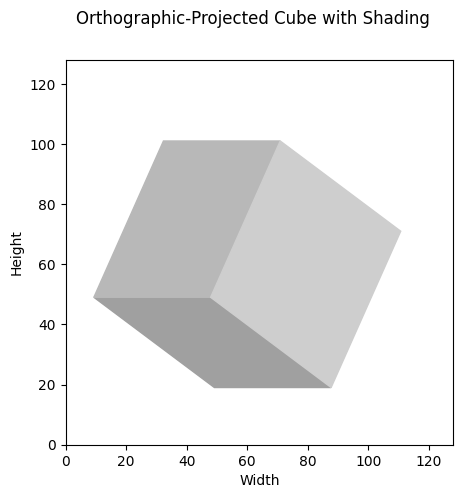

In [23]:
cube, normals = get_cube(center=(60., 60., 100), rotation_angles=[
                         30, 50, 0], scale=60., with_normals=True)
colors = get_face_colors(normals)
mask = get_face_mask(cube, normals)
projected_cube = project_cube_orthographic(cube)
plot_projected_cube(
    projected_cube, figtitle="Orthographic-Projected Cube with Shading", colors=colors, face_mask=mask)

### b)

How would you describe your result? Compare it against the visualization of the dolly zoom. When does the perspective projection look most similar to the orthographic projection?

To confirm your analysis, plot a cube with center `(0, 0, 150)` and the same rotation angles `(30, 50, 0)` which you project with a camera matrix with focal lengths of `10000`.

### b) 
 
你如何描述你的结果？比较它对可视化的多莉变焦。透视投影在什么时候看起来与正射影最相似？ 
 
为了确认你的分析，绘制一个中心为`（0,0,150）`和相同旋转角度为`（30,50,0）`的立方体，你用焦距为`10000`的相机矩阵投影它。

1. 在你的代码里，透视投影是通过 `get_perspective_projection(x_c, K)` 实现的。
其中，x_c 是三维空间中的点坐标，K 是相机内参矩阵。

核心公式（针孔模型）：$x_s = K * x_c$

其中，K 的主点 (cx, cy) 默认设置为图像中心 (W/2, H/2)。

2. 为什么 center=(0, 0, z) 能显示在图片中心？
当你把 cube 的 center 设置为 (0, 0, z)，cube 的空间中心点就是 (0, 0, z)。
经过投影后，空间点 (0, 0, z) 会变成像素点 (cx, cy)，也就是图像的中心。
这是因为 K 的第三列就是主点 (cx, cy)，它决定了空间原点投影到图像的哪个位置。

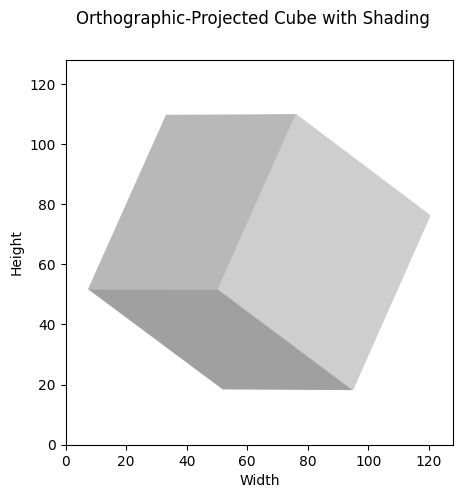

In [24]:
###########################
#### Exercise Function ####
###########################
# Insert your code here

K = get_camera_intrinsics(fx=10000, fy=10000)
cude, normals = get_cube(center=(0, 0, 150), rotation_angles=[
                         30, 50, 0], with_normals=True)
projected_cube = project_cube(cude, K)
colors = get_face_colors(normals)
mask = get_face_mask(cude, normals)
plot_projected_cube(
    projected_cube, figtitle="Orthographic-Projected Cube with Shading", colors=colors, face_mask=mask)

## 2.3 Panorama Stitching using DLT

In the second part of the exercise, we have a look at homographies and how they can be used to stitch together photos!

使用DLT进行全景拼接 
 
在练习的第二部分，我们来看看同音异义词以及如何使用它们将照片拼接在一起！

Let's first import the two images we want to stich together and the pre-computed point pairs.

In [25]:
# Load images
img1 = cv2.cvtColor(cv2.imread('./image-1.jpg'), cv2.COLOR_BGR2RGB)
# 原图片是RGB, cv2.imread读取的图像是BGR, 这里需要RGB，cv2.cvtColor将图像从BGR颜色空间转换为RGB颜色空间
# 这对于OpenCV读取的图像是必要的，因为OpenCV默认使用BGR格式。
# BGR是蓝色、绿色和红色的顺序，而RGB是红色、绿色和蓝色的顺序。
img2 = cv2.cvtColor(cv2.imread('./image-2.jpg'), cv2.COLOR_BGR2RGB)

# Load matching points
npz_file = np.load('./panorama_points.npz')
# Load points from the npz file
# npz_file是一个字典，包含了两个键'points_source'和'points_target'，分别对应源图像和目标图像中的匹配点。
# points_source和points_target是两个数组，分别表示源图像和目标图像中的匹配点。
# points_source是源图像中的匹配点，points_target是目标图像中的匹配点。
# 这些点用于图像配准和拼接。
points_source = npz_file['points_source']
points_target = npz_file['points_target']

Let's have a look at the two images

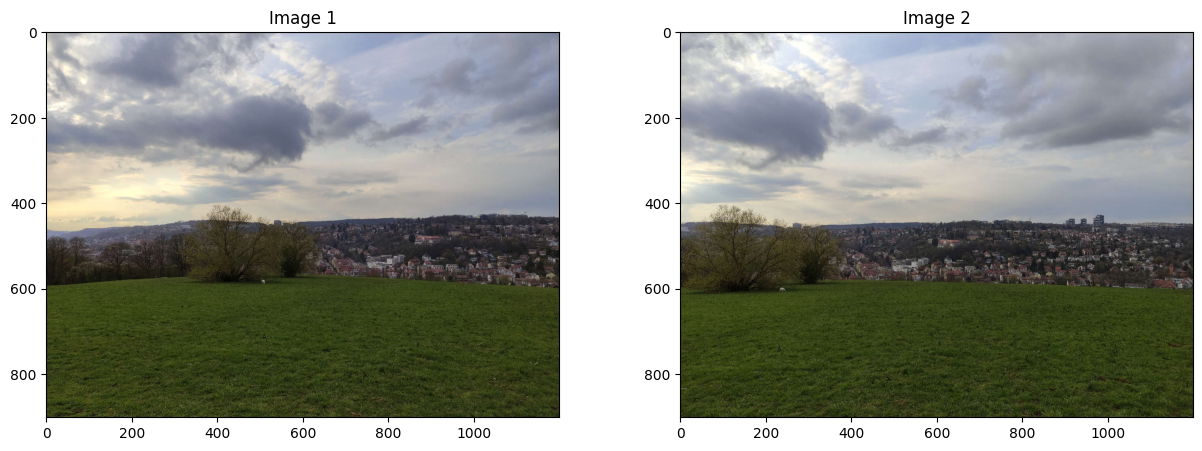

In [26]:
# Let's visualize the images
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(121)  # 121表示1行2列的第1个子图
ax1.set_title('Image 1')
ax2 = f.add_subplot(122)  # 122表示1行2列的第2个子图
ax2.set_title('Image 2')
# 显示图像1和图像2
ax1.imshow(img1)
ax2.imshow(img2)

Let's also have a look at some correspondence pairs! For this, the `draw_matches` function is provided.

In [27]:
###########################
##### Helper Function #####
###########################
def draw_matches(img1, points_source, img2, points_target):
    ''' Returns an image with matches drawn onto the images.
    '''
    r, c = img1.shape[:2]
    r1, c1 = img2.shape[:2]

    output_img = np.zeros((max([r, r1]), c + c1, 3), dtype='uint8')
    output_img[:r, :c, :] = np.dstack([img1])
    output_img[:r1, c:c + c1, :] = np.dstack([img2])

    for p1, p2 in zip(points_source, points_target):
        (x1, y1) = p1[:2]
        (x2, y2) = p2[:2]

        cv2.circle(output_img, (int(x1), int(y1)), 10, (0, 255, 255), 10)
        cv2.circle(output_img, (int(x2) + c, int(y2)), 10, (0, 255, 255), 10)

        cv2.line(output_img, (int(x1), int(y1)),
                 (int(x2) + c, int(y2)), (0, 255, 255), 5)

    return output_img

(99, 3) (99, 3)
Source points (first 5): [[809. 544.   1.]
 [469. 440.   1.]
 [429. 415.   1.]
 [869. 549.   1.]
 [796. 536.   1.]]
Target points (first 5): [[552.        551.          1.       ]
 [187.        446.          1.       ]
 [138.        417.6000061   1.       ]
 [608.        554.          1.       ]
 [540.        544.          1.       ]]


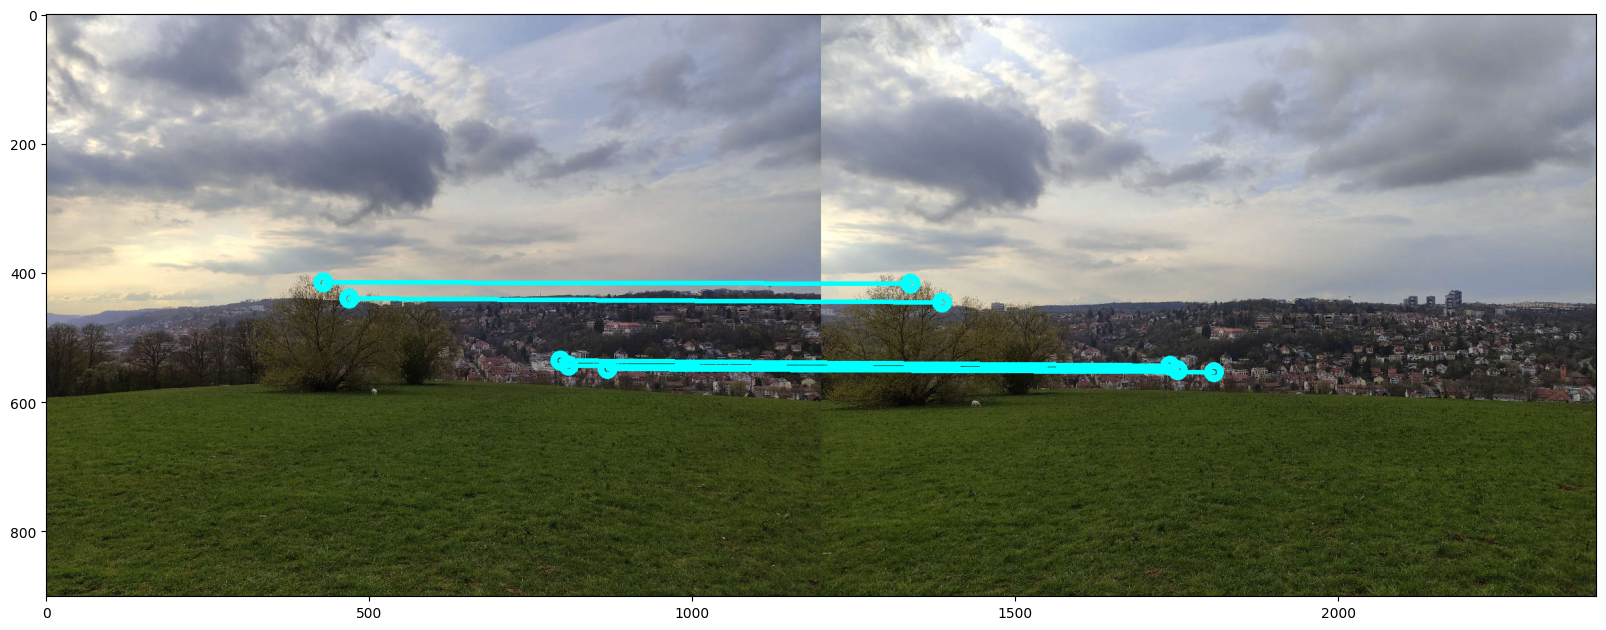

In [28]:
f = plt.figure(figsize=(20, 10))
print(points_source.shape, points_target.shape)
# 共有99个匹配点，points_source和points_target的形状都是(99, 3)
vis = draw_matches(img1, points_source[:5], img2, points_target[:5])
# 打印前5个匹配点的坐标，观察是齐次坐标还是非齐次坐标 -> 齐次坐标
print("Source points (first 5):", points_source[:5])
print("Target points (first 5):", points_target[:5])
# 只绘制前5个匹配点， 因为三维的点共有15个自由度， 至少需要5个点才能精准匹配
plt.imshow(vis)

### a)

After looking at the correspondences, let's stitch the images together! In order to stich together the images, we need a function to return the 2x9 "A_i" matrix discussed in the lecture for a given 2D correspondence pair `xi_vector` and `xi_prime_vector` (these are 3D homogeneous vectors).

### a) 
 
查看完对应关系后，让我们将这些图像拼接在一起！为了将图像拼接在一起，我们需要一个函数来返回讲座中讨论的2x9`A_i`矩阵，用于给定的2D对应对`xi_vector`和`xi_prime_vector`（这些是3D齐次向量）。

In [29]:
###########################
#### Exercise Function ####
###########################
def get_Ai(xi_vector, xi_prime_vector):
    ''' Returns the A_i matrix discussed in the lecture for input vectors.

    Args:
        xi_vector (array): the x_i vector in homogeneous coordinates
        xi_vector_prime (array): the x_i_prime vector in homogeneous coordinates
    '''
    assert (xi_vector.shape == (3,) and xi_prime_vector.shape == (3,))
    # 断言，确保输入的 xi_vector 和 xi_prime_vector 都是齐次坐标，且形状为 (3,)

    # Insert your code here

    Ai = np.array([[xi_vector[0], xi_vector[1], 1, 0, 0, 0, -xi_prime_vector[0] * xi_vector[0], -xi_prime_vector[0] * xi_vector[1], -xi_prime_vector[0]],
                   [0, 0, 0, xi_vector[0], xi_vector[1], 1, -xi_prime_vector[1] * xi_vector[0], -xi_prime_vector[1] * xi_vector[1], -xi_prime_vector[1]]], dtype=np.float32)

    assert (Ai.shape == (2, 9))
    return Ai

### b)

Using `get_Ai`, write a function `get_A` which returns the A matrix of size 2Nx9.

In [30]:
###########################
#### Exercise Function ####
###########################
def get_A(points_source, points_target):
    ''' Returns the A matrix discussed in the lecture.

    Args:
        points_source (array): 3D homogeneous points from source image
        points_target (array): 3D homogeneous points from target image
    '''
    N = points_source.shape[0]

    assert (points_source.shape ==
            points_target.shape and points_source.shape[1] == 3)
    # Insert your code here
    A = np.vstack([get_Ai(points_source[i], points_target[i])
                  for i in range(N)])
    # 将每个点的 A_i 矩阵堆叠成一个大的矩阵 A
    # A 的形状应该是 (2*N, 9)，其中 N 是点的数量
    print(A.shape)
    A = A.reshape(2 * N, 9)
    assert (A.shape == (2*N, 9))
    return A

### c)

Next, implement the function `get_homography` which returns the homography H for point corrspondence pairs. You should obtain H by performing the Direct Linear Transformation (DLT) algorithm (consisting of 3 steps).

接下来，实现函数`get_homography`，该函数返回点对应对的单应性H。您应该通过执行直接线性变换（DLT）算法（由3个步骤组成）来获得H。

*Hint 1*: ˙uoᴉʇɔunɟ ∀ʇǝƃ ǝɥʇ ƃuᴉsn xᴉɹʇɐɯ ∀ ǝɥʇ uᴉɐʇqo ʇsɹᴉɟ

*Hint 2*: ˙(pʌs˙ƃlɐuᴉl˙du ƃuᴉsn ƃǝ) ∀ uo pΛS ɯɹoɟɹǝd 'ʇxǝu

*Hint 3*: ˙xᴉɹʇɐɯ Λ pǝsodsuɐɹʇ ǝɥʇ ɟo ǝnlɐʌ ʇsɐl ǝɥʇ ʇɔǝlǝs 'ʎllɐuᴉɟ

In [31]:
###########################
#### Exercise Function ####
###########################
def get_homography(points_source, points_target):
    ''' Returns the homography H.

    Args:
        points_source (array): 3D homogeneous points from source image
        points_target (array): 3D homogeneous points from target image        
    '''

    # Insert your code here
    A = get_A(points_source, points_target)
    # 计算 A 的奇异值分解
    U, S, Vt = np.linalg.svd(A)
    # 取 Vt 的最后一行作为 H 的一维向量
    h = Vt[-1, :]  # Vt 的最后一行对应于最小奇异值
    H = h.reshape(3, 3)  # 将一维向量转换为 3x3 矩阵

    assert (H.shape == (3, 3))
    return H

We need a function which takes in the two images and the calculated homography and it returns the stiched image in a format which we can display easy with matplotlib. This function is provided in the following.

In [32]:
###########################
##### Helper Function #####
###########################
def stich_images(img1, img2, H):
    ''' Stitches together the images via given homography H.

    Args:
        img1 (array): image 1
        img2 (array): image 2
        H (array): homography
    '''

    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32(
        [[0, 0], [0, rows1], [cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    temp_points = np.float32(
        [[0, 0], [0, rows2], [cols2, rows2], [cols2, 0]]).reshape(-1, 1, 2)

    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate(
        (list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min, -y_min]

    H_translation = np.array([[1, 0, translation_dist[0]], [
                             0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv2.warpPerspective(
        img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1],
               translation_dist[0]:cols1+translation_dist[0]] = img1

    return output_img

Finally, we can have a look at our panorama! 

(198, 9)


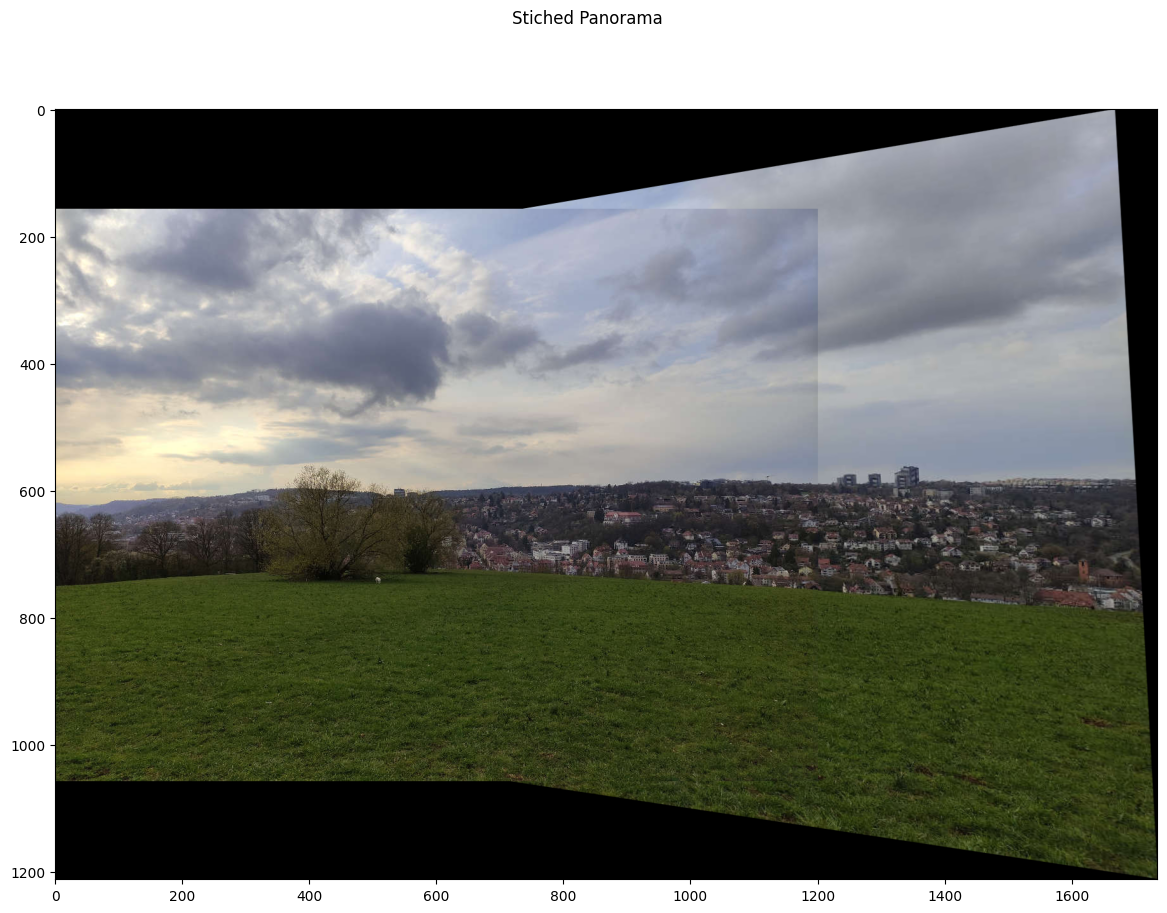

In [33]:
H = get_homography(points_target, points_source)
stiched_image = stich_images(img1, img2, H)
fig = plt.figure(figsize=(15, 10))
fig.suptitle("Stiched Panorama")
plt.imshow(stiched_image)

### d)

Now, it's your turn: Create your own panorama! Go out and take two photos with your smartphone or camera and save them to your computer. Make sure that you only change the angle of the phone/camera, not the position! Save them to the lecture exercise folder and cange the file paths for `img1` and `img2` below to your own images!

### d) 
 
现在，轮到你了：创建你自己的全景！出门用智能手机或相机拍两张照片，保存到电脑里。确保你只改变手机/相机的角度，而不是位置！将它们保存到讲座练习文件夹中，并将“img1”和“img2”的文件路径更改为您自己的图像！

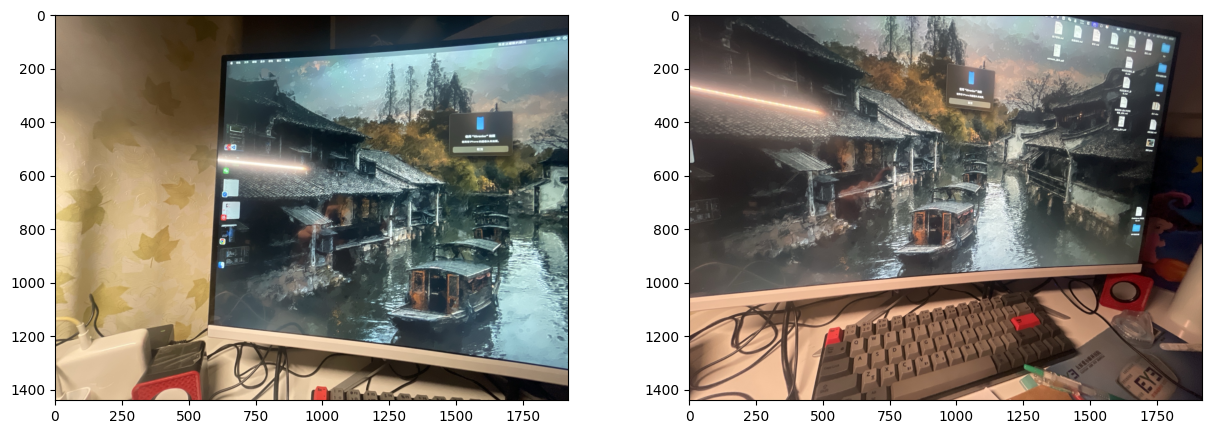

In [34]:
###########################
#### Exercise Function ####
###########################
# Load images
img1 = cv2.cvtColor(cv2.imread('./self-image1.jpeg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('./self-image2.jpeg'), cv2.COLOR_BGR2RGB)
# Let's visualize the images
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.imshow(img1)
ax2.imshow(img2)

For obtaining the homography, we need correspondence pairs. In the following we provide a function for this based on feature matching.

In [35]:
###########################
##### Helper Function #####
###########################
def get_keypoints(img1, img2):
    orb = cv2.ORB_create(nfeatures=2000)

    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
    bf = cv2.BFMatcher_create(cv2.NORM_HAMMING)

    # Find matching points
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good.append(m)
    p_source = np.float32(
        [keypoints1[good_match.queryIdx].pt for good_match in good]).reshape(-1, 2)
    p_target = np.float32(
        [keypoints2[good_match.trainIdx].pt for good_match in good]).reshape(-1, 2)
    N = p_source.shape[0]
    p_source = np.concatenate([p_source, np.ones((N, 1))], axis=-1)
    p_target = np.concatenate([p_target, np.ones((N, 1))], axis=-1)
    return p_source, p_target

Let's have a look at your own panorama!

Source points (first 5): [[809. 544.   1.]
 [469. 440.   1.]
 [429. 415.   1.]
 [869. 549.   1.]
 [796. 536.   1.]]
Target points (first 5): [[552.        551.          1.       ]
 [187.        446.          1.       ]
 [138.        417.6000061   1.       ]
 [608.        554.          1.       ]
 [540.        544.          1.       ]]
(250, 9)


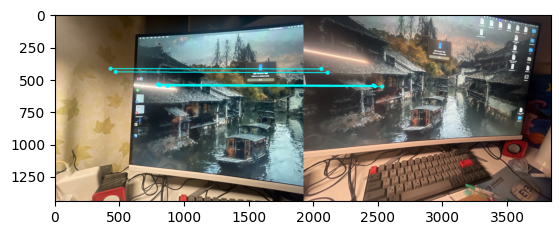

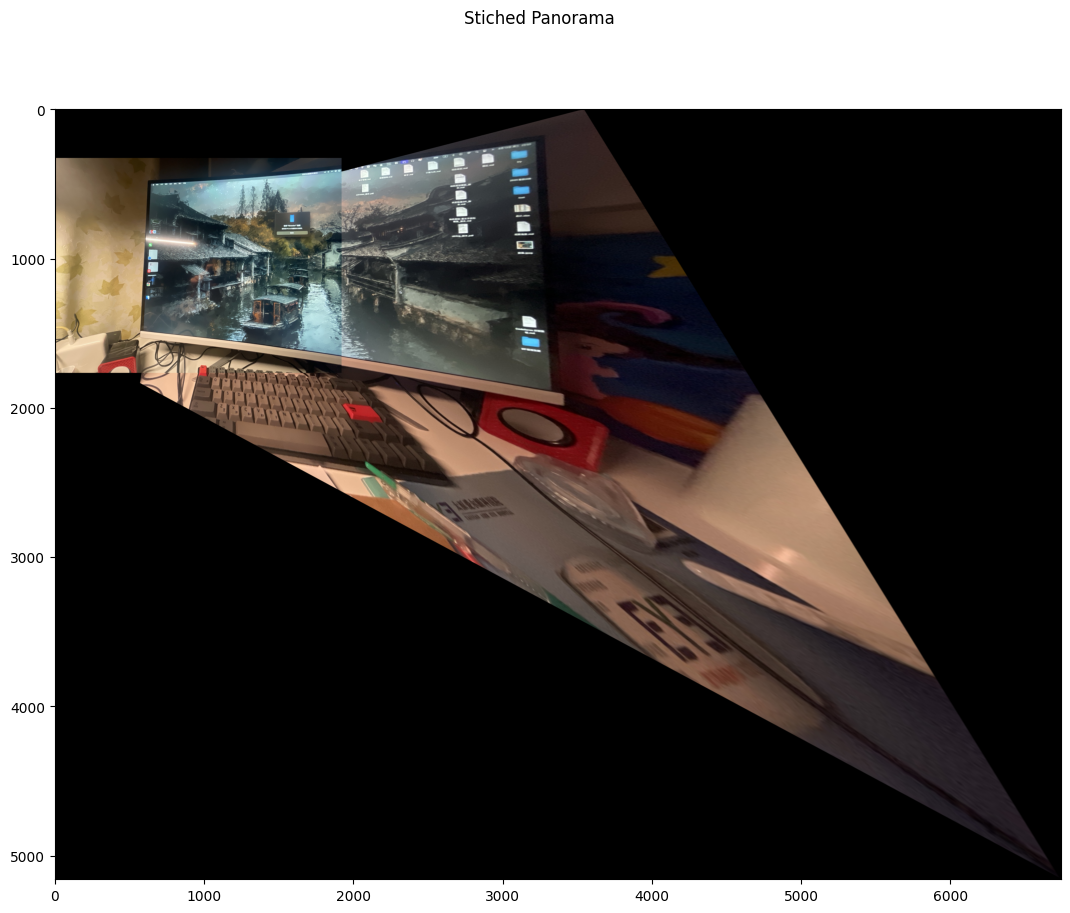

In [37]:
p_source, p_target = get_keypoints(img1, img2)
vis = draw_matches(img1, points_source[:5], img2, points_target[:5])
# 打印前5个匹配点的坐标，观察是齐次坐标还是非齐次坐标 -> 齐次坐标
print("Source points (first 5):", points_source[:5])
print("Target points (first 5):", points_target[:5])
# 只绘制前5个匹配点， 因为三维的点共有15个自由度， 至少需要5个点才能精准匹配
plt.imshow(vis)
H = get_homography(p_target, p_source)
stiched_image = stich_images(img1, img2, H)
fig = plt.figure(figsize=(15, 10))
fig.suptitle("Stiched Panorama")
plt.imshow(stiched_image)

Great job! You now gained hands-on experience in the fields of image formation and panorama stitching!